# Credit Card Fraud Detection

This notebook is inspired by https://www.kaggle.com/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets

In [256]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Data

The datasets contains transactions made by credit cards in September 2013 by european cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [257]:
data_path = "data/creditcard.csv"

In [258]:
df = pd.read_csv(data_path)

## Get an overview of the data

In [259]:
# check how the data looks like
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [260]:
# ~300k observations, 31 features
df.shape

(284807, 31)

In [261]:
# check column types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

In [262]:
# check for missing values
df.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [263]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


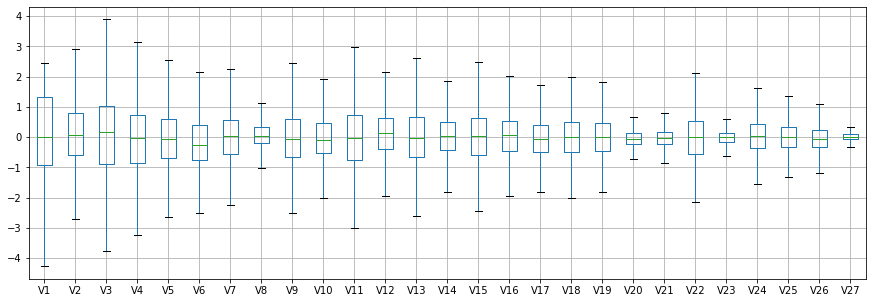

In [264]:
pca_features = [f"V{i}" for i in range(1,28)]
df[pca_features].boxplot(figsize=(15,5), showfliers=False)

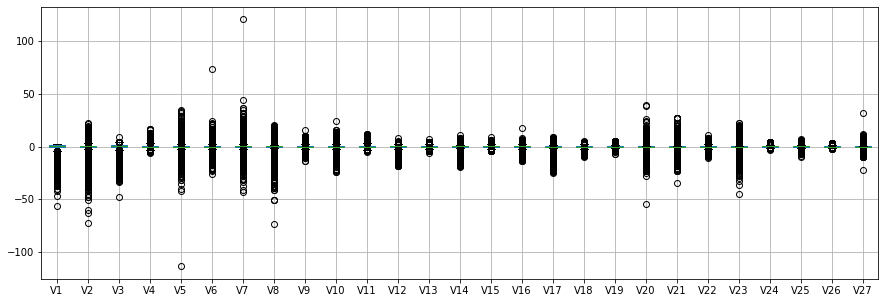

In [265]:
df[pca_features].boxplot(figsize=(15,5), showfliers=True)

Class
0    0.998273
1    0.001727
Name: Time, dtype: float64

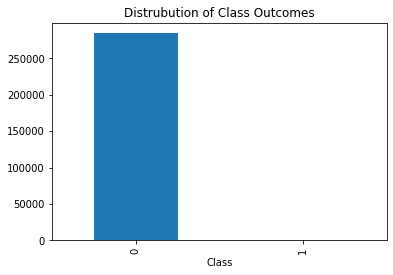

In [266]:
# check label distribution
df.groupby(by="Class").count()["Time"].plot(kind="bar", title="Distrubution of Class Outcomes")
df.groupby(by="Class").count()["Time"] / df.shape[0]

#### Highly imbalanced data set. 99,8% of the data set is y=0 and only 0.17% is y=1

/Users/patricktu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


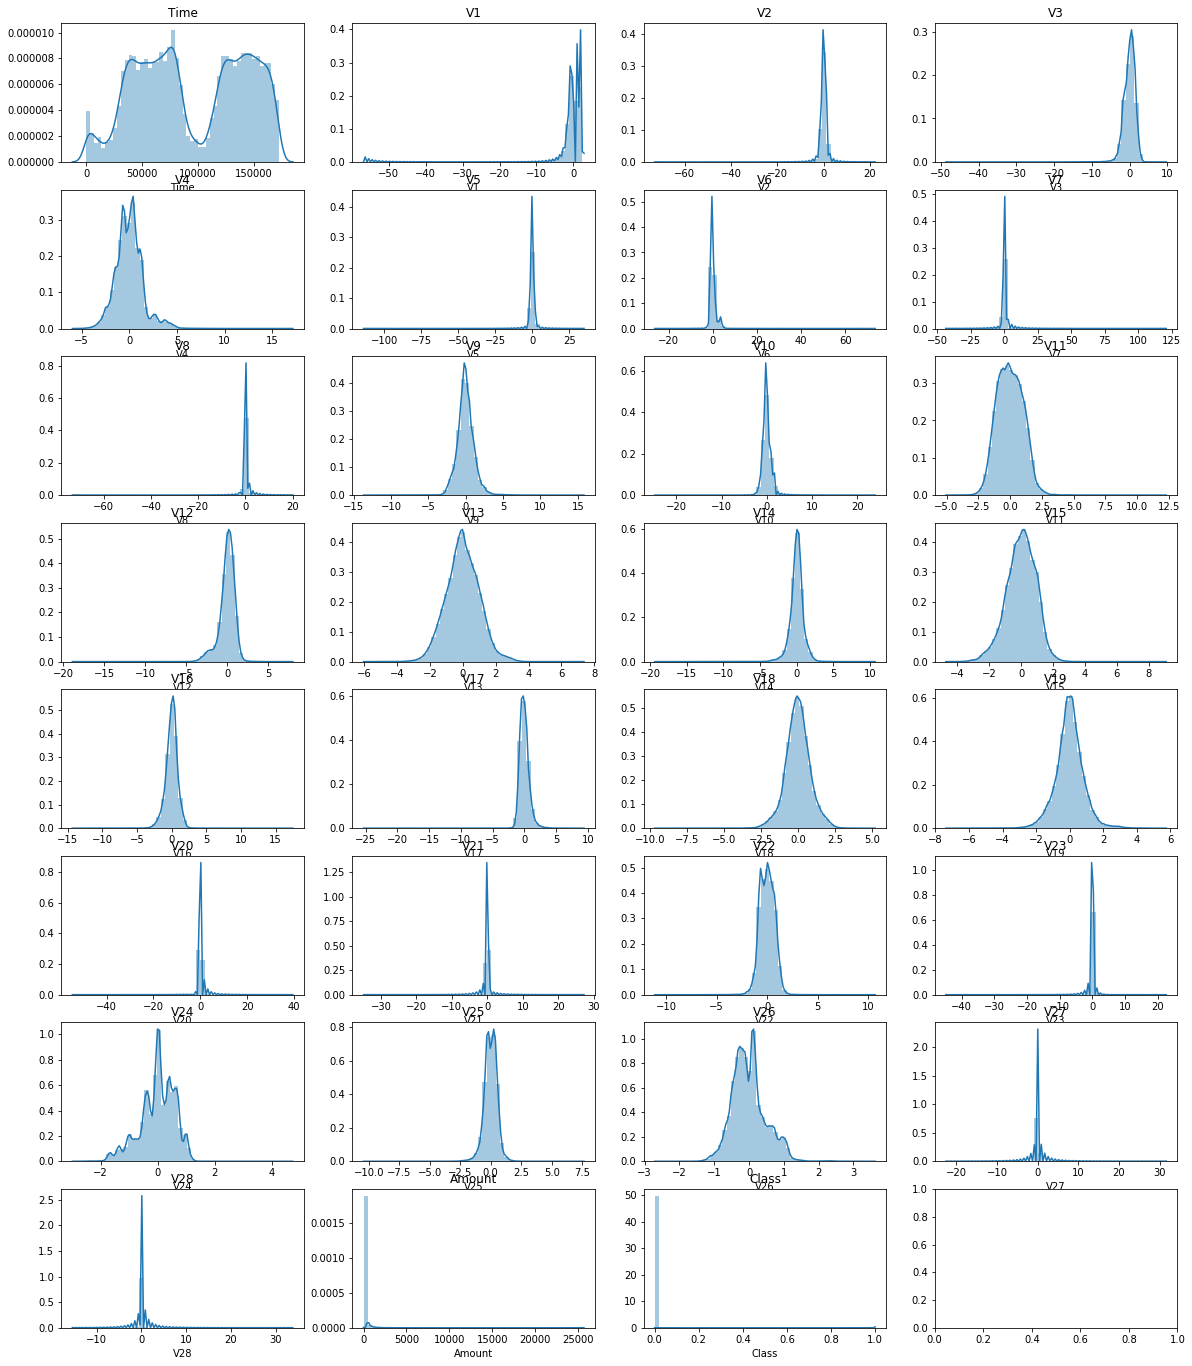

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [267]:
# check distribution of features
fig, ax = plt.subplots(8,4, figsize=(20,24))
counter = 0

for col in df.columns:
    i = int(counter / 4) # row
    j = counter % 4 # col
    plt.figure()
    sns.distplot(df[col], ax=ax[i,j])
    ax[i,j].set_title(col)
    counter+=1

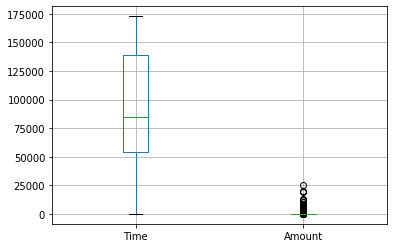

In [268]:
df.boxplot(column=["Time", "Amount"])

## Preprocess the Data

### Rescaling the Data
- The data has been preprocessed via PCA by the data owners, hence these features are already scaled accordingly
- Time and Amount have not been rescaled yet

In [269]:
# use robust scaler as Amount has quite some outliers
from sklearn.preprocessing import RobustScaler

In [270]:
scaler = RobustScaler()

In [271]:
df["Time"] = scaler.fit_transform(df["Time"].values.reshape(-1, 1))
df["Amount"] = scaler.fit_transform(df["Amount"].values.reshape(-1, 1))

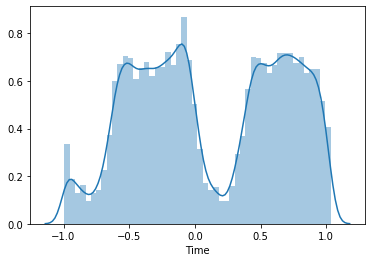

In [272]:
sns.distplot(df["Time"])

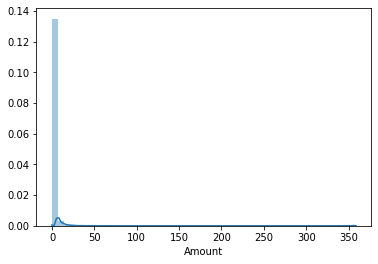

In [273]:
sns.distplot(df["Amount"])

In [274]:
df[["Time", "Amount"]].head()

,Time,Amount
0,-0.994983,1.783274
1,-0.994983,-0.269825
2,-0.994972,4.983721
3,-0.994972,1.418291
4,-0.994960,0.670579


### Train Test Split

In [275]:
from sklearn.model_selection import train_test_split

In [276]:
X = df.iloc[:, ~ df.columns.isin(["Class"])]
y = df.iloc[:, df.columns.isin(["Class"])]

In [277]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(227845, 30)
(227845, 1)
(56962, 30)
(56962, 1)


In [278]:
# base rate in training set
y_train.mean()

Class    0.001729
dtype: float64

In [279]:
# base rate in test set
y_test.mean()

Class    0.00172
dtype: float64

### Create more balanced training set

In [280]:
X_train_pos = X_train[y_train["Class"]==1]
y_train_pos = y_train[y_train["Class"]==1]
X_train_neg = X_train[y_train["Class"]==0]
X_train_neg_sampled = X_train_neg.sample(n=X_train_pos.shape[0])
X_train_neg_sampled.shape

(394, 30)

In [281]:
y_train_neg_sampled = y_train.loc[X_train_neg_sampled.index]

In [282]:

X_tr_sampled = pd.concat([X_train_pos, X_train_neg_sampled], axis=0)
y_tr_sampled = pd.concat([y_train_pos, y_train_neg_sampled], axis=0)
X_tr_sampled.shape

(788, 30)

In [283]:
X_tr_sampled.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
276071,0.965601,2.091900,-0.757459,-1.192258,-0.755458,-0.620324,-0.322077,-1.082511,0.117200,-0.140927,...,0.037438,0.288253,0.831939,0.142007,0.592615,-0.196143,-0.136676,0.020182,-0.015470,-0.028645
44556,-0.501662,-4.566342,3.353451,-4.572028,3.616119,-2.493138,-1.090000,-5.551433,0.447783,-2.424414,...,-0.249128,2.674466,-0.020880,-0.302447,-0.086396,-0.516060,-0.295102,0.195985,0.141115,-0.293440
251891,0.832435,1.878230,1.325630,-2.333469,4.233151,1.355184,-0.853508,0.716025,-0.164910,-1.502345,...,-0.226108,-0.152131,-0.360736,0.043414,-0.242380,0.171098,-0.002601,-0.026667,0.005238,-0.208761
150677,0.107931,-13.086519,7.352148,-18.256576,10.648505,-11.731476,-3.659167,-14.873658,8.810473,-5.418204,...,-1.376298,2.761157,-0.266162,-0.412861,0.519952,-0.743909,-0.167808,-2.498300,-0.711066,0.116118
149869,0.086937,-1.108478,3.448953,-6.216972,3.021052,-0.529901,-2.551375,-2.001743,1.092432,-0.836098,...,-0.068598,0.825951,1.144170,0.208559,-0.295497,-0.690232,-0.364749,0.229327,0.208830,-0.055893


Text(0.5, 1.0, 'Class distribution')

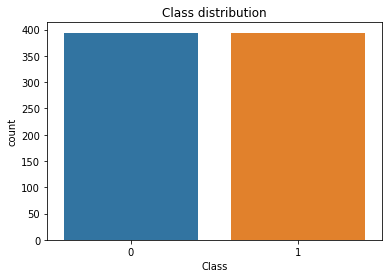

In [284]:
sns.countplot("Class", data = y_tr_sampled)
plt.title("Class distribution")

##  Logistic Regression

In [285]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

In [286]:
X_tr, X_va, y_tr, y_va = train_test_split(X_tr_sampled, y_tr_sampled)

In [287]:
model = LogisticRegression()
model.fit(X_tr, y_tr)
y_hat_tr = model.predict(X_tr)
y_hat_va = model.predict(X_va)
y_hat_test = model.predict(X_test)

/Users/patricktu/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/patricktu/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Train Performance

In [288]:
print(classification_report(y_tr, y_hat_tr))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96       298
           1       0.99      0.92      0.95       293

    accuracy                           0.96       591
   macro avg       0.96      0.96      0.96       591
weighted avg       0.96      0.96      0.96       591



In [289]:
roc_auc_score(y_tr, model.predict_proba(X_tr)[:,1])

0.9922005634835193

### Validation Performance (hold-out set from balanced train set)

In [170]:
print(classification_report(y_va, y_hat_va))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95       105
           1       0.94      0.96      0.95        92

    accuracy                           0.95       197
   macro avg       0.95      0.95      0.95       197
weighted avg       0.95      0.95      0.95       197



In [290]:
roc_auc_score(y_va, model.predict_proba(X_va)[:,1])

0.9682343234323433

### Test Performance

In [171]:
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     56864
           1       0.03      0.93      0.05        98

    accuracy                           0.94     56962
   macro avg       0.51      0.93      0.51     56962
weighted avg       1.00      0.94      0.97     56962



In [182]:
roc_auc_score(y_test, model.predict_proba(X_test)[:,1])

0.9856425248067713

## Train on original train set

In [291]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_hat_tr = model.predict(X_train)
y_hat_test = model.predict(X_test)

/Users/patricktu/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/patricktu/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Train Performance

In [184]:
print(classification_report(y_train, y_hat_tr))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       0.89      0.63      0.74       394

    accuracy                           1.00    227845
   macro avg       0.95      0.81      0.87    227845
weighted avg       1.00      1.00      1.00    227845



In [292]:
roc_auc_score(y_train, model.predict_proba(X_train)[:,1])

0.9809714802855849

### Test Performance

In [185]:
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.86      0.58      0.70        98

    accuracy                           1.00     56962
   macro avg       0.93      0.79      0.85     56962
weighted avg       1.00      1.00      1.00     56962



In [186]:
roc_auc_score(y_test, model.predict_proba(X_test)[:,1])

0.9747984449829453

## Random Forest

In [294]:
from sklearn.ensemble import RandomForestClassifier

In [295]:
X_tr, X_va, y_tr, y_va = train_test_split(X_tr_sampled, y_tr_sampled)
model = RandomForestClassifier()
model.fit(X_tr, y_tr)
y_hat_tr = model.predict(X_tr)
y_hat_va = model.predict(X_va)
y_hat_test = model.predict(X_test)

/Users/patricktu/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/patricktu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


### Train Performance

In [297]:
print(classification_report(y_tr, y_hat_tr))
auc = roc_auc_score(y_tr, model.predict_proba(X_tr)[:,1])
print(auc)

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       296
           1       1.00      0.97      0.99       295

    accuracy                           0.99       591
   macro avg       0.99      0.99      0.99       591
weighted avg       0.99      0.99      0.99       591

0.9999198350893266


### Validation Performance (hold-out set from balanced train set)

In [298]:
print(classification_report(y_va, y_hat_va))
auc = roc_auc_score(y_va, model.predict_proba(X_va)[:,1])
print(auc)

              precision    recall  f1-score   support

           0       0.90      0.96      0.93        98
           1       0.96      0.90      0.93        99

    accuracy                           0.93       197
   macro avg       0.93      0.93      0.93       197
weighted avg       0.93      0.93      0.93       197

0.9711399711399711


### Test Performance

In [299]:
print(classification_report(y_test, y_hat_test))
auc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
print(auc)

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.06      0.88      0.11        98

    accuracy                           0.98     56962
   macro avg       0.53      0.93      0.55     56962
weighted avg       1.00      0.98      0.99     56962

0.9746886233390373


## SVM

In [300]:
from sklearn.svm import SVC

In [304]:
X_tr, X_va, y_tr, y_va = train_test_split(X_tr_sampled, y_tr_sampled)
model = SVC(probability=True)
model.fit(X_tr, y_tr)
y_hat_tr = model.predict(X_tr)
y_hat_va = model.predict(X_va)
y_hat_test = model.predict(X_test)

/Users/patricktu/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/patricktu/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


### Train Performance

In [305]:
print(classification_report(y_tr, y_hat_tr))
auc = roc_auc_score(y_tr, model.predict_proba(X_tr)[:,1])
print(auc)

              precision    recall  f1-score   support

           0       0.93      0.99      0.96       282
           1       0.99      0.93      0.96       309

    accuracy                           0.96       591
   macro avg       0.96      0.96      0.96       591
weighted avg       0.96      0.96      0.96       591

0.9940209782184581


### Validation Performance (hold-out set from balanced train set)

In [306]:
print(classification_report(y_va, y_hat_va))
auc = roc_auc_score(y_va, model.predict_proba(X_va)[:,1])
print(auc)

              precision    recall  f1-score   support

           0       0.95      0.91      0.93       112
           1       0.89      0.94      0.91        85

    accuracy                           0.92       197
   macro avg       0.92      0.93      0.92       197
weighted avg       0.93      0.92      0.92       197

0.9798319327731093


### Test Performance

In [307]:
print(classification_report(y_test, y_hat_test))
auc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
print(auc)

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     56864
           1       0.03      0.92      0.05        98

    accuracy                           0.94     56962
   macro avg       0.51      0.93      0.51     56962
weighted avg       1.00      0.94      0.97     56962

0.9762733209490887
